In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DA450')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, register_keras_serializable
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess images
main_path = "Animals"
folders = ['cats', 'dogs', 'snakes']
img_size = (64, 64)
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.8
}

In [ ]:
images = []
labels = []
label_map = {'cats': 0, 'dogs': 1, 'snakes': 2}

for label in folders:
    folder_path = os.path.join(main_path, label)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                image = Image.open(file_path).convert('RGB')
                image = image.resize(img_size)
                image = np.array(image) / 255.0
                images.append(image)
                labels.append(label_map[label])
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

In [ ]:
# Convert to numpy arrays
X = np.array(images)
y = to_categorical(np.array(labels), num_classes=3)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),


    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
@register_keras_serializable()
def recall_class_2(y_true, y_pred):
    class_id = 2
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)

    true_positives = K.sum(K.cast((y_true_class == class_id) & (y_pred_class == class_id), dtype='float32'))
    possible_positives = K.sum(K.cast(y_true_class == class_id, dtype='float32'))

    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', recall_class_2])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=3, verbose=1)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=60,
                    callbacks=[reduce_lr],
                    class_weight=class_weights)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.4495 - loss: 2.3989 - recall_class_2: 0.6453 - val_accuracy: 0.3100 - val_loss: 1.9442 - val_recall_class_2: 1.0000 - learning_rate: 0.0010
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5609 - loss: 1.2244 - recall_class_2: 0.8009 - val_accuracy: 0.3133 - val_loss: 1.9698 - val_recall_class_2: 1.0000 - learning_rate: 0.0010
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5812 - loss: 1.0131 - recall_class_2: 0.8211 - val_accuracy: 0.4950 - val_loss: 1.1307 - val_recall_class_2: 0.8605 - learning_rate: 0.0010
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5648 - loss: 1.0180 - recall_class_2: 0.8350 - val_accuracy: 0.5050 - val_loss: 0.9991 - val_recall_class_2: 0.6354 - learning_rate: 0.0010
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5788 - loss: 0.9526 - recall_class_2: 0.8659 - val_accuracy: 0.4983 - val_loss: 0.9409 - val_recall_class_2: 0.4906 - learnin

Test Recall (class 2): 97.27%


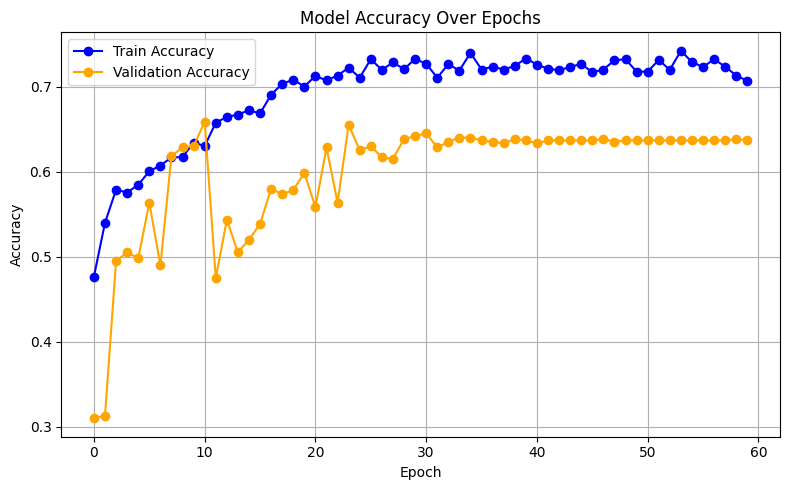

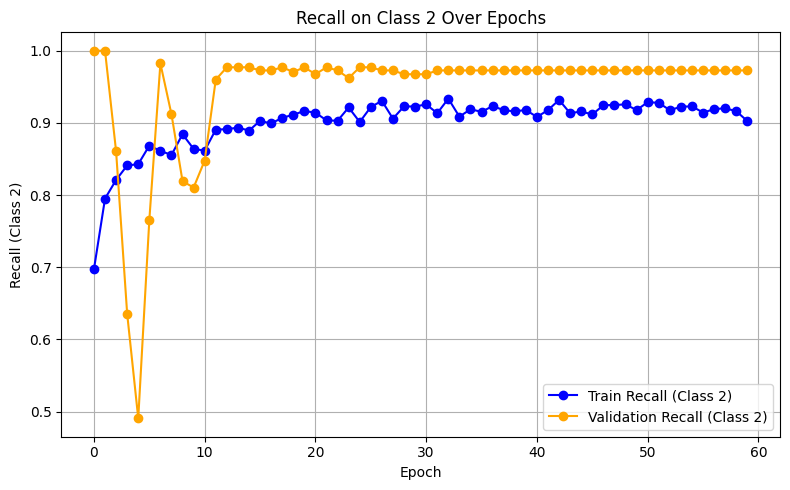

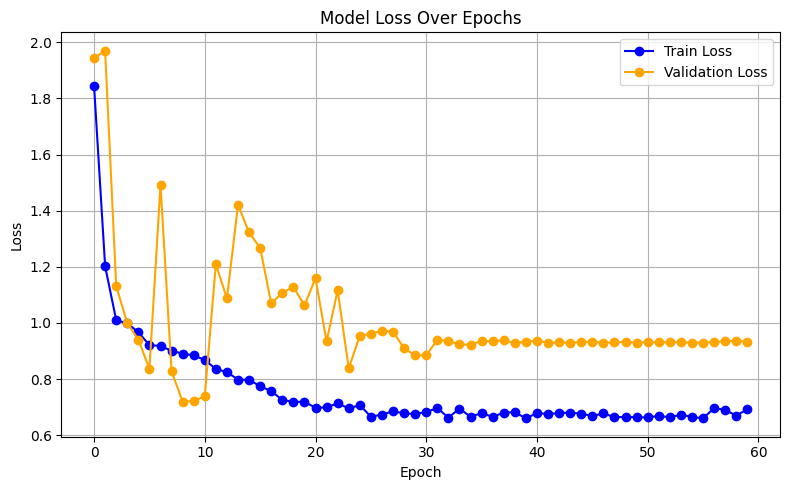

In [ ]:
# Evaluate recall for class 2
_, _, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Recall (class 2): {test_recall * 100:.2f}%")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot recall for class 2
plt.figure(figsize=(8, 5))
plt.plot(history.history['recall_class_2'], label='Train Recall (Class 2)', color='blue', marker='o')
plt.plot(history.history['val_recall_class_2'], label='Validation Recall (Class 2)', color='orange', marker='o')
plt.title('Recall on Class 2 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall (Class 2)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Number of misclassified class 2 samples: 5


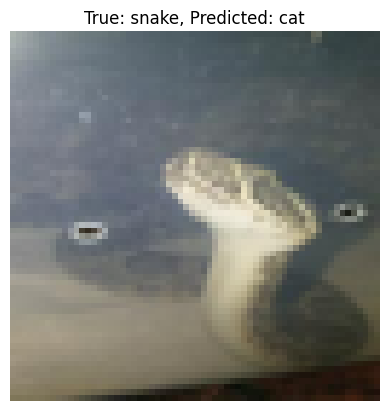

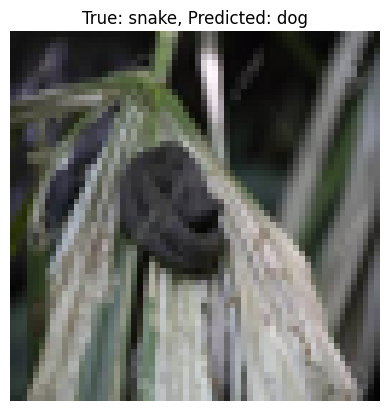

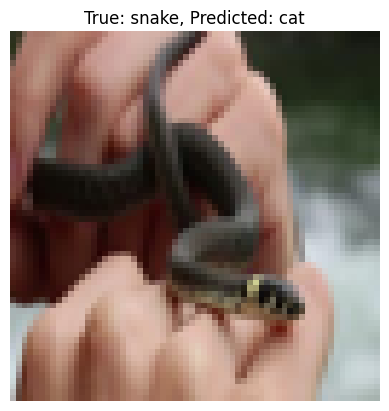

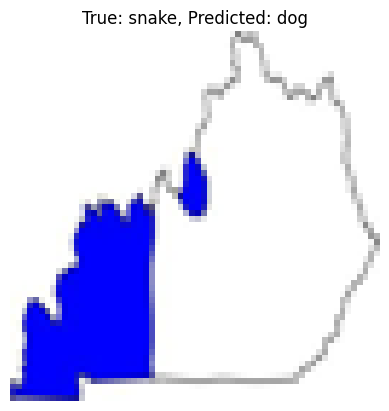

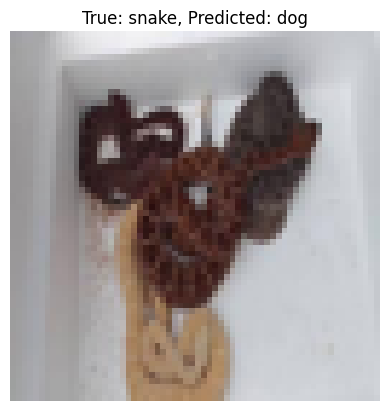

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
misclassified_class2_indices = np.where((y_true == 2) & (y_pred != 2))[0]

print(f"Number of misclassified class 2 samples: {len(misclassified_class2_indices)}")

for idx in misclassified_class2_indices:
    img = X_test[idx].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {folders[y_true[idx]][:-1]}, Predicted: {folders[y_pred[idx]][:-1]}")
    plt.axis('off')
    plt.show()

Number of correctly classified class 2 samples: 181


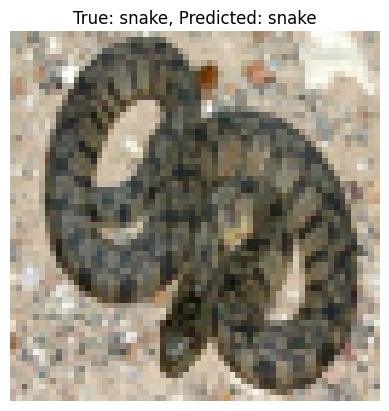

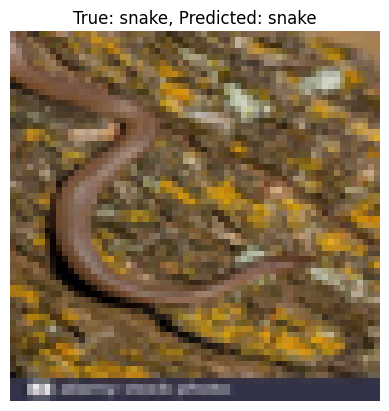

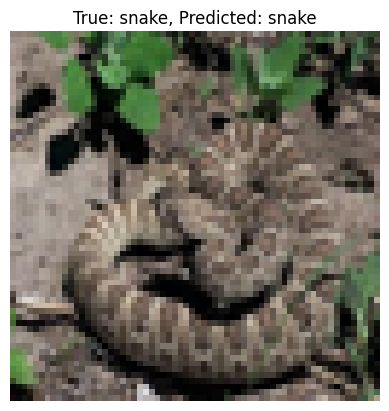

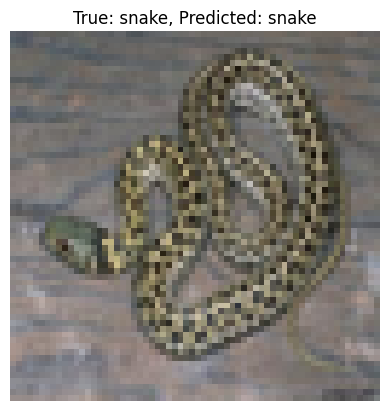

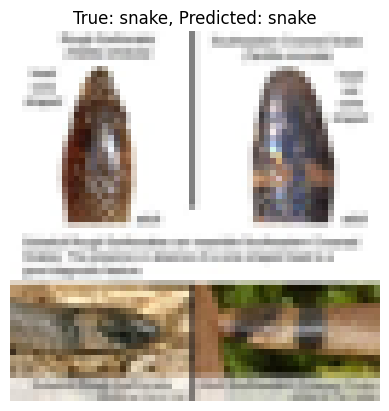

In [ ]:
classified_class2_indices = np.where((y_true == 2) & (y_pred == 2))[0]

print(f"Number of correctly classified class 2 samples: {len(classified_class2_indices)}")

for i, idx in enumerate(classified_class2_indices):
    img = X_test[idx].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {folders[y_true[idx]][:-1]}, Predicted: {folders[y_pred[idx]][:-1]}")
    plt.axis('off')
    plt.show()

    if i == 4:
        break

In [ ]:
model.save('model8.keras')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,563,851 (5.97 MB)

 Trainable params: 520,963 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,041,928 (3.97 MB)